# **Neuropolis-X1**
### **Building an artificial intelligence system for human brain activity prediction (EEG, fMRI) with machine learning, deep learning, and large language models**

#### Maël Donoso, Ouroboros Neurotechnologies (https://ouroboros-neurotechnologies.com/)
*18th March 2025*

This first extension (X1) of Neuropolis includes twelve Notebooks:

*01: fMRI Preprocessing*

*02: EEG Preprocessing*

*03: Classification Models*

*04: Regression Models*

*05: Neural Networks*

*06: Convolutional Neural Networks*

***07: Recurrent Neural Networks***

*08: Transformers*

*09: Large Language Models*

*10: Large Language Model Chain-of-Thought*

*11: Large Language Model Fine-Tuning*

*12: Large Multimodal Model*

### Notebook 07

# **Recurrent Neural Networks**

## **1. Classification**

We define a **recurrent neural network model** for a classification task, using the **Adam optimizer** and the **binary cross-entropy loss function**. Our objective is to predict whether the fMRI signal increases or decreases in our brain regions of interest. We run the model on all subjects, except sub-xp102 who has a missing condition, and use the eegfmriNF condition as the train set, the eegNF condition as the validation set, and the fmriNF condition as the test set. The recurrent neural network model predicts the evolution of the fMRI signal with an accuracy slightly higher than the baseline, but shows signs of overfitting. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import os

In [2]:
# Define the raw data path. 
raw_data_path = '../../Neuropolis/ds002336-download/'

# Define the preprocessed data path. 
preprocessed_data_path = '../neuropolis-x1_preprocessed_data/'

# Define the results path. 
results_path = '../neuropolis-x1_results/'

In [3]:
# Load the targets. 
with open(preprocessed_data_path + 'dict_targets.p', 'rb') as file:
    dict_targets = pickle.load(file)

# Load the features, the targets, and the baseline for the classification task. 
with open(preprocessed_data_path + 'classification/dict_features_classification_basis.p', 'rb') as file:
    dict_features_basis_class = pickle.load(file)
with open(preprocessed_data_path + 'classification/dict_features_classification_sequence.p', 'rb') as file:
    dict_features_sequence_class = pickle.load(file)
with open(preprocessed_data_path + 'classification/dict_targets_classification_basis.p', 'rb') as file:
    dict_targets_basis_class = pickle.load(file)
with open(preprocessed_data_path + 'classification/dict_baseline_classification_basis.p', 'rb') as file:
    dict_baseline_basis_class = pickle.load(file)

In [4]:
# Define the list of subjects, removing sub-xp102 who has a missing condition. 
subjects = ['sub-xp1' + str(x).zfill(2) for x in range(1, 11)]
subjects.remove('sub-xp102')
subject = subjects[0]

# Retrieve the list of all targets. 
targets = list(dict_targets[subject]['eegfmriNF'].keys())

# Select a sequence length. 
selected_sequence_length = 5

# Retrieve the number of scans. 
nb_scans_class = dict_targets[subject]['eegfmriNF']['Frontal Pole'].shape[0] - 1
nb_scans_reg = dict_targets[subject]['eegfmriNF']['Frontal Pole'].shape[0]

# Define the batch size for the neural networks models. 
batch_size = 32

In [5]:
# Define a function to run a recurrent neural network model for a classification task. 
def run_rnn_classification(NeuralNetworkModel, dict_features_basis, dict_targets_basis, dict_baseline_basis):

    # Define the dictionaries and the summary DataFrame. 
    dict_models = dict()
    dict_history = dict()
    dict_predictions = dict()
    df_summary = pd.DataFrame()

    # Iterate through all subjects. 
    for subject in subjects:

        # Display current subject. 
        print(subject)

        # Clone the Neural Network model. 
        PredictorBrain = tf.keras.models.clone_model(NeuralNetworkModel)

        # Retrieve the general features of the train set, validation set, and test set. 
        X_tr_basis = dict_features_basis[subject]['eegfmriNF']
        X_va_basis = dict_features_basis[subject]['eegNF']
        X_te_basis = dict_features_basis[subject]['fmriNF']

        # Rescale features variables. 
        scaler = StandardScaler()
        X_tr_basis_standardized = scaler.fit_transform(X_tr_basis)
        X_va_basis_standardized = scaler.transform(X_va_basis)
        X_te_basis_standardized = scaler.transform(X_te_basis)

        # Define the particular features arrays. 
        X_tr_standardized = np.zeros((nb_scans_class - selected_sequence_length, selected_sequence_length + 1, X_tr_basis_standardized.shape[1]))
        X_va_standardized = np.zeros((nb_scans_class - selected_sequence_length, selected_sequence_length + 1, X_va_basis_standardized.shape[1]))
        X_te_standardized = np.zeros((nb_scans_class - selected_sequence_length, selected_sequence_length + 1, X_te_basis_standardized.shape[1]))
        for scan in range(nb_scans_class - selected_sequence_length):
            for time_step in range(selected_sequence_length + 1):
                X_tr_standardized[scan, time_step, :] = X_tr_basis_standardized[scan + time_step, :].ravel()
                X_va_standardized[scan, time_step, :] = X_va_basis_standardized[scan + time_step, :].ravel()
                X_te_standardized[scan, time_step, :] = X_te_basis_standardized[scan + time_step, :].ravel()

        # Retrieve the targets of the train set, validation set, and test set. 
        Y_tr_basis = dict_targets_basis[subject]['eegfmriNF']
        Y_va_basis = dict_targets_basis[subject]['eegNF']
        Y_te_basis = dict_targets_basis[subject]['fmriNF']

        # Define the particular targets arrays. 
        Y_tr = Y_tr_basis[selected_sequence_length:, :]
        Y_va = Y_va_basis[selected_sequence_length:, :]
        Y_te = Y_te_basis[selected_sequence_length:, :]

        # Retrieve the baseline of the train set and determine the baseline accuracy. 
        Baseline = dict_baseline_basis[subject]['eegfmriNF'][selected_sequence_length:, :]
        accuracy_baseline = np.mean(Baseline == Y_te)

        # End training when accuracy stops improving. 
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 6, 
                                                          restore_best_weights = True)

        # Define the loss function, optimizer, and metrics to track during training. 
        PredictorBrain.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                               loss = 'binary_crossentropy', metrics = ['binary_accuracy'])

        # Fit the model. 
        NeuralNetworkHistory = PredictorBrain.fit(
            x = X_tr_standardized, y = Y_tr,
            validation_data = (X_va_standardized, Y_va), 
            batch_size = batch_size, epochs = 50,
            shuffle = True, callbacks = [early_stopping], verbose = 0
        )

        # Evaluate the test accuracy. 
        (loss_test, accuracy_test) = PredictorBrain.evaluate(X_te_standardized, Y_te, batch_size = batch_size)
        print(f'test loss: {loss_test:.4f}, test accuracy: {accuracy_test:.4f}')

        # Compute the predictions from the neural network. 
        Y_pred = PredictorBrain.predict(X_te_standardized)

        # Convert the probabilities to binary predictions. 
        Y_pred_binary = (Y_pred > 0.5).astype(int)

        # Store the performance metrics and the shapes of the arrays in the DataFrame. 
        df_summary.loc[subject, 'loss_train'] = NeuralNetworkHistory.history['loss'][-1]
        df_summary.loc[subject, 'loss_valid'] = NeuralNetworkHistory.history['val_loss'][-1]
        df_summary.loc[subject, 'loss_test'] = loss_test
        df_summary.loc[subject, 'accuracy_train'] = NeuralNetworkHistory.history['binary_accuracy'][-1]
        df_summary.loc[subject, 'accuracy_valid'] = NeuralNetworkHistory.history['val_binary_accuracy'][-1]
        df_summary.loc[subject, 'accuracy_test'] = accuracy_test
        df_summary.loc[subject, 'accuracy_baseline'] = accuracy_baseline
        df_summary.loc[subject, 'above_baseline'] = str(accuracy_test > accuracy_baseline)
        df_summary.loc[subject, 'X_tr.shape'] = str(X_tr_standardized.shape)
        df_summary.loc[subject, 'X_va.shape'] = str(X_va_standardized.shape)
        df_summary.loc[subject, 'X_te.shape'] = str(X_te_standardized.shape)
        df_summary.loc[subject, 'Y_tr.shape'] = str(Y_tr.shape)
        df_summary.loc[subject, 'Y_va.shape'] = str(Y_va.shape)
        df_summary.loc[subject, 'Y_te.shape'] = str(Y_te.shape)

        # Store the trained model, the model history, and the predictions in the dictionary. 
        dict_models[subject] = PredictorBrain
        dict_history[subject] = NeuralNetworkHistory
        dict_predictions[subject] = Y_pred_binary
    
    return dict_models, dict_history, dict_predictions, df_summary

In [6]:
# Define a function to plot the results of the recurrent neural network training. 
def plot_rnn_classification(dict_history_class, title):
    
    # Display the graph. 
    fig, axes = plt.subplots(nrows = 9, ncols = 2, figsize = (12, 52))
    fig.suptitle(title, fontsize = 14, y = 0.895)
    subject_index = 0

    # Iterate through all subjects. 
    for subject in subjects:

        # Retrieve the history. 
        NeuralNetworkHistory = dict_history_class[subject]

        # Plot loss values. 
        axes[subject_index, 0].plot(NeuralNetworkHistory.history['loss'], label = 'train loss', color = 'blue')
        axes[subject_index, 0].plot(NeuralNetworkHistory.history['val_loss'], label = 'val loss', color = 'green')
        axes[subject_index, 0].set_title(str(subject) + ' valid. loss: {:.3f} (mean last 3)'.format(
            np.mean(NeuralNetworkHistory.history['val_loss'][-3:]) # Take the mean of the last three values. 
        ))
        axes[subject_index, 0].set_xlabel('Epoch')
        axes[subject_index, 0].set_ylabel('Loss value')
        axes[subject_index, 0].legend()

        # Plot accuracy values. 
        axes[subject_index, 1].plot(NeuralNetworkHistory.history['binary_accuracy'], label = 'train acc', color = 'blue')
        axes[subject_index, 1].plot(NeuralNetworkHistory.history['val_binary_accuracy'], label = 'val acc', color = 'green')
        axes[subject_index, 1].set_title(str(subject) + ' valid. accuracy: {:.3f} (mean last 3)'.format(
            np.mean(NeuralNetworkHistory.history['val_binary_accuracy'][-3:]) # Take the mean of the last three values. 
        ))
        axes[subject_index, 1].set_xlabel('Epoch')
        axes[subject_index, 1].set_ylabel('Accuracy')
        axes[subject_index, 1].legend();

        # Increment. 
        subject_index += 1

In [7]:
# Define the neural network model. 
tf.random.set_seed(0)
NeuralNetworkModel = tf.keras.Sequential()
input_dim = (dict_features_sequence_class[subject]['eegfmriNF'].shape[0], # Number of time steps. 
             int(dict_features_sequence_class[subject]['eegfmriNF'].shape[1] / (selected_sequence_length + 1))) # Number of features per time step. 

# Input layer. 
NeuralNetworkModel.add(tf.keras.layers.InputLayer(shape = input_dim))

# GRU layer. 
NeuralNetworkModel.add(tf.keras.layers.GRU(
    units = 256, activation = tf.keras.activations.relu, recurrent_dropout = 0.3
    ))
NeuralNetworkModel.add(tf.keras.layers.Dropout(0.5))

# Output layer. 
NeuralNetworkModel.add(tf.keras.layers.Dense(
    units = len(targets), activation = tf.keras.activations.sigmoid,
    kernel_initializer = tf.keras.initializers.VarianceScaling(scale = 1.0, seed = 0)))

# Print network summary. 
NeuralNetworkModel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 256)            │       488,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 49)             │        12,593 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 501,041 (1.91 MB)

 Trainable params: 501,041 (1.91 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Run the recurrent neural network model. 
dict_models_class, dict_history_class, dict_predictions_class, df_summary_class = run_rnn_classification(NeuralNetworkModel, 
                                                                                                         dict_features_basis_class, 
                                                                                                         dict_targets_basis_class, 
                                                                                                         dict_baseline_basis_class)

sub-xp101
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.5021 - loss: 0.7571 
test loss: 0.7653, test accuracy: 0.5028
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
sub-xp103
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.5165 - loss: 0.6963 
test loss: 0.6971, test accuracy: 0.5154
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
sub-xp104
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.5015 - loss: 0.7010 
test loss: 0.7019, test accuracy: 0.5011
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
sub-xp105
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.5137 - loss: 0.7351 
test loss: 0.7470, test accuracy: 0.5089
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
sub-xp106
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.5020 - loss: 0.7060 
test loss: 0.7049, test accuracy: 0.5019
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
sub-xp107
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.5168 - loss: 0.6956 
test loss: 0.6956, test accuracy: 0.5159
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19

In [9]:
# Display the results. 
print('Recurrent Neural Networks: Classification')
df_summary_class

Recurrent Neural Networks: Classification


,loss_train,loss_valid,loss_test,accuracy_train,accuracy_valid,accuracy_test,accuracy_baseline,above_baseline,X_tr.shape,X_va.shape,X_te.shape,Y_tr.shape,Y_va.shape,Y_te.shape
sub-xp101,0.626658,0.766888,0.765258,0.650326,0.524721,0.502840,0.480328,True,"(194, 6, 378)","(194, 6, 378)","(194, 6, 378)","(194, 49)","(194, 49)","(194, 49)"
sub-xp103,0.627619,0.710720,0.697066,0.642962,0.515674,0.515359,0.507995,True,"(194, 6, 378)","(194, 6, 378)","(194, 6, 378)","(194, 49)","(194, 49)","(194, 49)"
sub-xp104,0.652744,0.709065,0.701877,0.615085,0.509678,0.501052,0.498948,True,"(194, 6, 378)","(194, 6, 378)","(194, 6, 378)","(194, 49)","(194, 49)","(194, 49)"
sub-xp105,0.623148,0.724156,0.747018,0.651168,0.524826,0.508942,0.499158,True,"(194, 6, 378)","(194, 6, 378)","(194, 6, 378)","(194, 49)","(194, 49)","(194, 49)"
sub-xp106,0.648148,0.710650,0.704851,0.619503,0.505260,0.501894,0.494004,True,"(194, 6, 378)","(194, 6, 378)","(194, 6, 378)","(194, 49)","(194, 49)","(194, 49)"
sub-xp107,0.630227,0.719138,0.695639,0.643699,0.526615,0.515885,0.505049,True,"(194, 6, 378)","(194, 6, 378)","(194, 6, 378)","(194, 49)","(194, 49)","(194, 49)"
sub-xp108,0.652510,0.711119,0.700038,0.608037,0.505365,0.511677,0.500000,True,"(194, 6, 378)","(194, 6, 378)","(194, 6, 378)","(194, 49)","(194, 49)","(194, 49)"
sub-xp109,0.634706,0.716958,0.701185,0.636651,0.502420,0.506207,0.499369,True,"(194, 6, 378)","(194, 6, 378)","(194, 6, 378)","(194, 49)","(194, 49)","(194, 49)"
sub-xp110,0.638204,0.706356,0.701065,0.629076,0.516937,0.507679,0.504523,True,"(194, 6, 378)","(194, 6, 378)","(194, 6, 378)","(194, 49)","(194, 49)","(194, 49)"


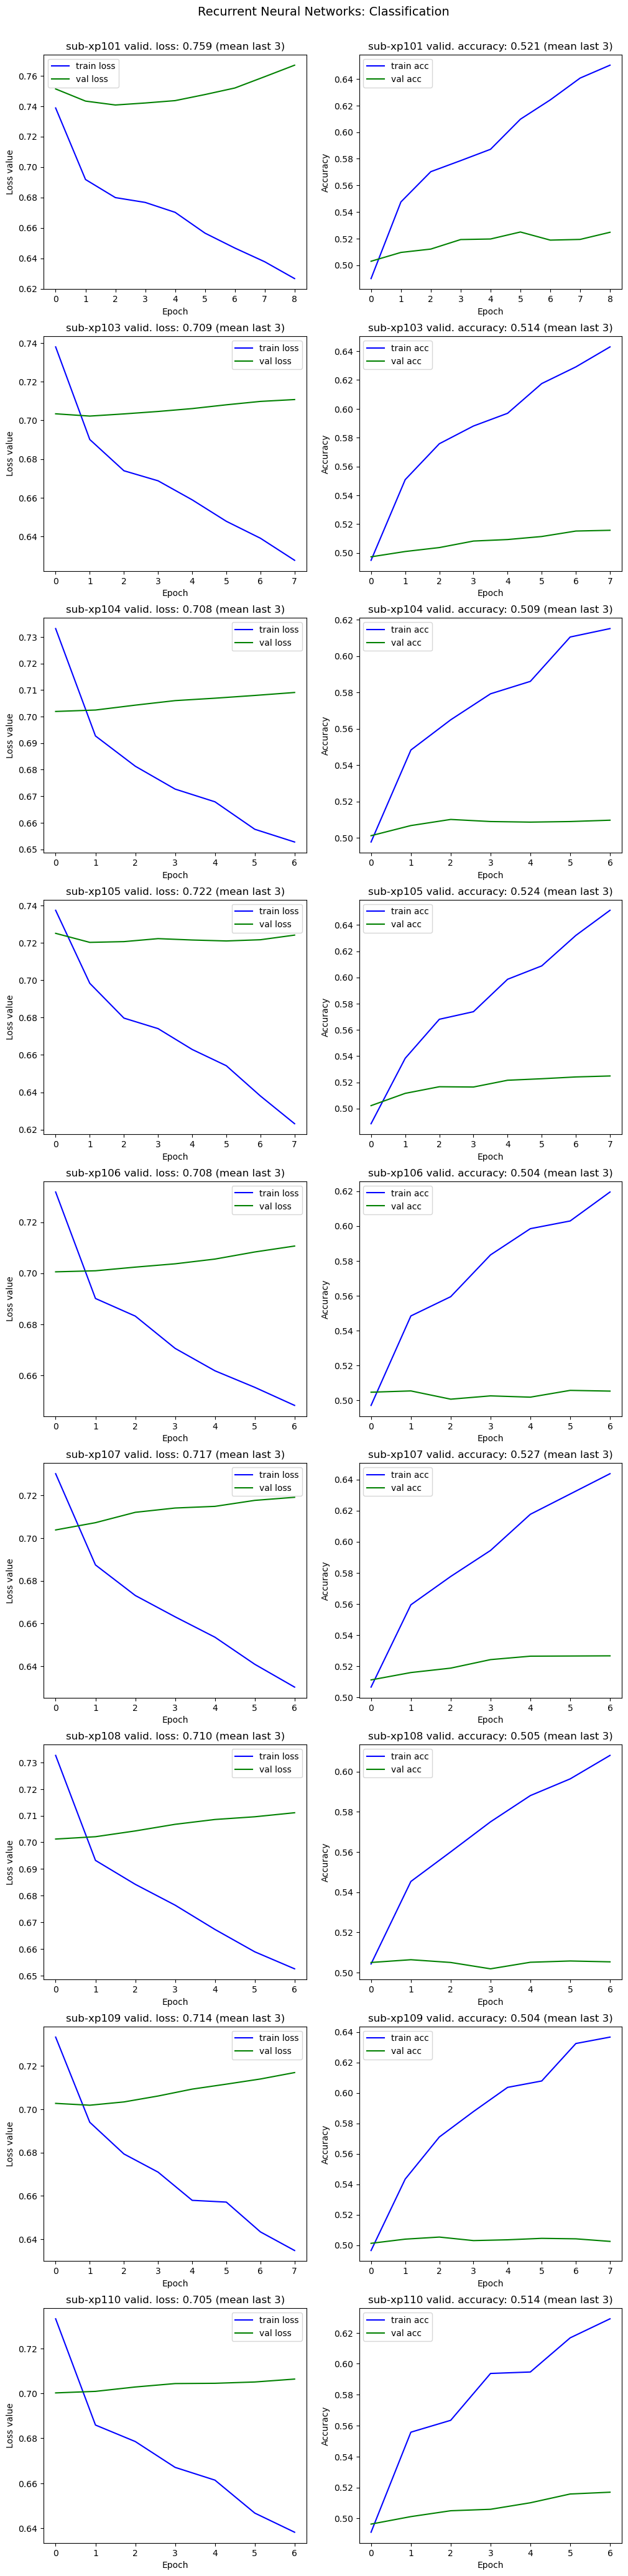

In [10]:
# Display the results. 
plot_rnn_classification(dict_history_class, title = 'Recurrent Neural Networks: Classification')

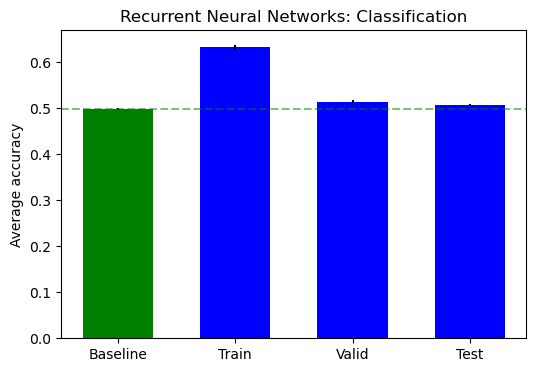

In [11]:
# Retrieve the average accuracy and the standard error of the accuracy. 
acc = [df_summary_class['accuracy_baseline'].mean(), 
       df_summary_class['accuracy_train'].mean(), 
       df_summary_class['accuracy_valid'].mean(), 
       df_summary_class['accuracy_test'].mean()]
acc_se = [np.std(df_summary_class['accuracy_baseline']) / np.sqrt(df_summary_class['accuracy_baseline'].shape[0]), 
          np.std(df_summary_class['accuracy_train']) / np.sqrt(df_summary_class['accuracy_train'].shape[0]), 
          np.std(df_summary_class['accuracy_valid']) / np.sqrt(df_summary_class['accuracy_valid'].shape[0]), 
          np.std(df_summary_class['accuracy_test']) / np.sqrt(df_summary_class['accuracy_test'].shape[0])]

# Display the average accuracy and its standard error in a bar plot. 
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 4))
axes.bar(range(4), acc, width = 0.6, color = ['green', 'blue', 'blue', 'blue'])
axes.errorbar(range(4), acc, yerr = acc_se, fmt = 'None', color = 'black')
axes.axhline(acc[0], 0, 1, color = 'green', linestyle = 'dashed', alpha = 0.5)
axes.set_xticks(range(4), labels = ['Baseline', 'Train', 'Valid', 'Test'])
axes.set_ylabel('Average accuracy')
axes.set_title('Recurrent Neural Networks: Classification');

## **2. Regression**

We define a **recurrent neural network model** for a regression task, using the **Adam optimizer** and the **mean squared error loss function**. Our objective is to predict the value of the fMRI signal in our brain regions of interest. We run the model on all subjects, except sub-xp102 who has a missing condition, and use the eegfmriNF condition as the train set, the eegNF condition as the validation set, and the fmriNF condition as the test set. Although a slight improvement over the baseline is observed on average, the recurrent neural network model does not generalize well beyond the train set, and its predictions tend to fall to the baseline level. 

In [12]:
# Load the features, the targets, and the baseline for the regression task. 
with open(preprocessed_data_path + 'regression/dict_features_regression_basis.p', 'rb') as file:
    dict_features_basis_reg = pickle.load(file)
with open(preprocessed_data_path + 'regression/dict_targets_regression_basis.p', 'rb') as file:
    dict_targets_basis_reg = pickle.load(file)
with open(preprocessed_data_path + 'regression/dict_targets_regression_sequence.p', 'rb') as file:
    dict_targets_sequence_reg = pickle.load(file)
with open(preprocessed_data_path + 'regression/dict_baseline_regression_basis.p', 'rb') as file:
    dict_baseline_basis_reg = pickle.load(file)
with open(preprocessed_data_path + 'regression/dict_baseline_regression_sequence.p', 'rb') as file:
    dict_baseline_sequence_reg = pickle.load(file)

In [13]:
# Define the Mean Squared Error function. 
def MSE(y, y_pred):
    return np.mean(np.square(y - y_pred))

In [14]:
# Define the Mean Absolute Error function. 
def MAE(y, y_pred):
    return np.mean(np.abs(y - y_pred))

In [15]:
# Define the Residual Sum of Squares function. 
def RSS(y, y_pred):
    return np.sum(np.square(y - y_pred))

In [16]:
# Define a function to run a recurrent neural network model for a regression task. 
def run_rnn_regression(NeuralNetworkModel, dict_features_basis, dict_targets_basis, dict_baseline_basis):

    # Define the dictionaries and the summary DataFrame. 
    dict_models = dict()
    dict_history = dict()
    dict_predictions = dict()
    df_summary = pd.DataFrame()

    # Iterate through all subjects. 
    for subject in subjects:

        # Display current subject. 
        print(subject)

        # Clone the Neural Network model. 
        PredictorBrain = tf.keras.models.clone_model(NeuralNetworkModel)

        # Retrieve the general features of the train set, validation set, and test set. 
        X_tr_basis = dict_features_basis[subject]['eegfmriNF']
        X_va_basis = dict_features_basis[subject]['eegNF']
        X_te_basis = dict_features_basis[subject]['fmriNF']

        # Rescale features variables. 
        scaler = StandardScaler()
        X_tr_basis_standardized = scaler.fit_transform(X_tr_basis)
        X_va_basis_standardized = scaler.transform(X_va_basis)
        X_te_basis_standardized = scaler.transform(X_te_basis)

        # Define the particular features arrays. 
        X_tr_standardized = np.zeros((nb_scans_reg - selected_sequence_length, selected_sequence_length + 1, X_tr_basis_standardized.shape[1]))
        X_va_standardized = np.zeros((nb_scans_reg - selected_sequence_length, selected_sequence_length + 1, X_va_basis_standardized.shape[1]))
        X_te_standardized = np.zeros((nb_scans_reg - selected_sequence_length, selected_sequence_length + 1, X_te_basis_standardized.shape[1]))
        for scan in range(nb_scans_reg - selected_sequence_length):
            for time_step in range(selected_sequence_length + 1):
                X_tr_standardized[scan, time_step, :] = X_tr_basis_standardized[scan + time_step, :].ravel()
                X_va_standardized[scan, time_step, :] = X_va_basis_standardized[scan + time_step, :].ravel()
                X_te_standardized[scan, time_step, :] = X_te_basis_standardized[scan + time_step, :].ravel()

        # Retrieve the targets of the train set, validation set, and test set. 
        Y_tr_basis = dict_targets_basis[subject]['eegfmriNF']
        Y_va_basis = dict_targets_basis[subject]['eegNF']
        Y_te_basis = dict_targets_basis[subject]['fmriNF']

        # Define the particular targets arrays. 
        Y_tr = Y_tr_basis[selected_sequence_length:, :]
        Y_va = Y_va_basis[selected_sequence_length:, :]
        Y_te = Y_te_basis[selected_sequence_length:, :]

        # Retrieve the baseline of the train set and determine the baseline accuracy. 
        Baseline = dict_baseline_basis[subject]['eegfmriNF'][selected_sequence_length:, :]

        # End training when accuracy stops improving. 
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 6, 
                                                          restore_best_weights = True)

        # Define the loss function, optimizer, and metrics to track during training. 
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.005, beta_1 = 0.9)
        PredictorBrain.compile(optimizer = optimizer, loss = 'mse', metrics = [tf.keras.metrics.MeanAbsoluteError()])

        # Fit the model. 
        NeuralNetworkHistory = PredictorBrain.fit(
            x = X_tr_standardized, y = Y_tr,
            validation_data = (X_va_standardized, Y_va), 
            batch_size = batch_size, epochs = 50,
            shuffle = True, callbacks = [early_stopping], verbose = 0
        )

        # Evaluate the test MSE and MAE. 
        (mse_test, mae_test) = PredictorBrain.evaluate(X_te_standardized, Y_te, batch_size = batch_size)
        print(f'test MSE: {mse_test:.4f}, test MAE: {mae_test:.4f}')

        # Compute the predictions from the neural network. 
        Y_pred = PredictorBrain.predict(X_te_standardized)

        # Evaluate the performance metrics. 
        mse_baseline = MSE(Y_te, Baseline)
        mae_baseline = MAE(Y_te, Baseline)
        rss_baseline = RSS(Y_te, Baseline)
        mse_model = MSE(Y_te, Y_pred)
        mae_model = MAE(Y_te, Y_pred)
        rss_model = RSS(Y_te, Y_pred)
        r2_model = 1 - (rss_model / rss_baseline)

        # Store the performance metrics and the shapes of the arrays in the DataFrame. 
        df_summary.loc[subject, 'mse_train'] = NeuralNetworkHistory.history['loss'][-1]
        df_summary.loc[subject, 'mse_valid'] = NeuralNetworkHistory.history['val_loss'][-1]
        df_summary.loc[subject, 'mse_test'] = mse_test
        df_summary.loc[subject, 'mae_train'] = NeuralNetworkHistory.history['mean_absolute_error'][-1]
        df_summary.loc[subject, 'mae_valid'] = NeuralNetworkHistory.history['val_mean_absolute_error'][-1]
        df_summary.loc[subject, 'mae_test'] = mae_test
        df_summary.loc[subject, 'mae_baseline'] = mae_baseline
        df_summary.loc[subject, 'r2_model'] = r2_model
        df_summary.loc[subject, 'X_tr.shape'] = str(X_tr_standardized.shape)
        df_summary.loc[subject, 'X_va.shape'] = str(X_va_standardized.shape)
        df_summary.loc[subject, 'X_te.shape'] = str(X_te_standardized.shape)
        df_summary.loc[subject, 'Y_tr.shape'] = str(Y_tr.shape)
        df_summary.loc[subject, 'Y_va.shape'] = str(Y_va.shape)
        df_summary.loc[subject, 'Y_te.shape'] = str(Y_te.shape)

        # Store the trained model, the model history, and the predictions in the dictionary. 
        dict_models[subject] = PredictorBrain
        dict_history[subject] = NeuralNetworkHistory
        dict_predictions[subject] = Y_pred
    
    return dict_models, dict_history, dict_predictions, df_summary

In [17]:
# Define a function to plot the results of the recurrent neural network training. 
def plot_rnn_regression(dict_history_reg, title):
    
    # Display the graph. 
    fig, axes = plt.subplots(nrows = 9, ncols = 2, figsize = (12, 52))
    fig.suptitle(title, fontsize = 14, y = 0.895)
    subject_index = 0

    # Iterate through all subjects. 
    for subject in subjects:

        # Retrieve the history. 
        NeuralNetworkHistory = dict_history_reg[subject]

        # Plot MSE values. 
        axes[subject_index, 0].plot(NeuralNetworkHistory.history['loss'], label = 'train MSE', color = 'blue')
        axes[subject_index, 0].plot(NeuralNetworkHistory.history['val_loss'], label = 'val MSE', color = 'green')
        axes[subject_index, 0].set_title(str(subject) + ' valid. MSE: {:.3f} (mean last 3)'.format(
            np.mean(NeuralNetworkHistory.history['val_loss'][-3:]) # Take the mean of the last three values. 
        ))
        axes[subject_index, 0].set_xlabel('Epoch')
        axes[subject_index, 0].set_ylabel('MSE')
        axes[subject_index, 0].legend()

        # Plot MAE values. 
        axes[subject_index, 1].plot(NeuralNetworkHistory.history['mean_absolute_error'], label = 'train MAE', color = 'blue')
        axes[subject_index, 1].plot(NeuralNetworkHistory.history['val_mean_absolute_error'], label = 'val MAE', color = 'green')
        axes[subject_index, 1].set_title(str(subject) + ' valid. MAE: {:.3f} (mean last 3)'.format(
            np.mean(NeuralNetworkHistory.history['val_mean_absolute_error'][-3:]) # Take the mean of the last three values. 
        ))
        axes[subject_index, 1].set_xlabel('Epoch')
        axes[subject_index, 1].set_ylabel('MAE')
        axes[subject_index, 1].legend();

        # Increment. 
        subject_index += 1

In [18]:
# Define the neural network model. 
tf.random.set_seed(0)
NeuralNetworkModel = tf.keras.Sequential()
input_dim = (dict_features_sequence_class[subject]['eegfmriNF'].shape[0], # Number of time steps. 
             int(dict_features_sequence_class[subject]['eegfmriNF'].shape[1] / (selected_sequence_length + 1))) # Number of features per time step. 

# Input layer. 
NeuralNetworkModel.add(tf.keras.layers.InputLayer(shape = input_dim))

# GRU layer. 
NeuralNetworkModel.add(tf.keras.layers.GRU(
    units = 256, activation = tf.keras.activations.relu, recurrent_dropout = 0.3, 
    return_sequences = True
    ))

# GRU layer. 
NeuralNetworkModel.add(tf.keras.layers.GRU(
    units = 64, activation = tf.keras.activations.relu, recurrent_dropout = 0.3
    ))
NeuralNetworkModel.add(tf.keras.layers.Dropout(0.5))

# Output layer. 
NeuralNetworkModel.add(tf.keras.layers.Dense(
    units = len(targets), activation = tf.keras.activations.sigmoid,
    kernel_initializer = tf.keras.initializers.VarianceScaling(scale = 1.0, seed = 0)))

# Print network summary. 
NeuralNetworkModel.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 194, 256)       │       488,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 64)             │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 49)             │         3,185 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 553,457 (2.11 MB)

 Trainable params: 553,457 (2.11 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Run the recurrent neural network model. 
dict_models_reg, dict_history_reg, dict_predictions_reg, df_summary_reg = run_rnn_regression(NeuralNetworkModel, 
                                                                                             dict_features_basis_reg, 
                                                                                             dict_targets_basis_reg, 
                                                                                             dict_baseline_basis_reg)

sub-xp101
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8299 - mean_absolute_error: 0.7269 
test MSE: 0.8284, test MAE: 0.7214
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
sub-xp103
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0813 - mean_absolute_error: 0.8408 
test MSE: 0.9472, test MAE: 0.7896
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
sub-xp104
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8748 - mean_absolute_error: 0.7592 
test MSE: 0.8778, test MAE: 0.7526
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
sub-xp105
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0581 - mean_absolute_error: 0.8362 
test MSE: 0.9656, test MAE: 0.7929
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
sub-xp106
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0402 - mean_absolute_error: 0.8197 
test MSE: 0.9831, test MAE: 0.7973
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
sub-xp107
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0070 - mean_absolute_error: 0.8264 
test MSE: 0.9689, test MAE: 0.8049
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
sub-

In [20]:
# Display the results. 
print('Recurrent Neural Networks: Regression')
df_summary_reg

Recurrent Neural Networks: Regression


,mse_train,mse_valid,mse_test,mae_train,mae_valid,mae_test,mae_baseline,r2_model,X_tr.shape,X_va.shape,X_te.shape,Y_tr.shape,Y_va.shape,Y_te.shape
sub-xp101,0.655453,0.796420,0.828407,0.621682,0.693978,0.721435,0.717371,-0.016890,"(195, 6, 378)","(195, 6, 378)","(195, 6, 378)","(195, 49)","(195, 49)","(195, 49)"
sub-xp103,0.765624,1.018445,0.947239,0.688193,0.802611,0.789610,0.791543,-0.006314,"(195, 6, 378)","(195, 6, 378)","(195, 6, 378)","(195, 49)","(195, 49)","(195, 49)"
sub-xp104,0.548732,0.813251,0.877754,0.564606,0.676934,0.752560,0.754163,-0.009286,"(195, 6, 378)","(195, 6, 378)","(195, 6, 378)","(195, 49)","(195, 49)","(195, 49)"
sub-xp105,0.709478,1.001549,0.965603,0.636426,0.795635,0.792922,0.802868,0.005605,"(195, 6, 378)","(195, 6, 378)","(195, 6, 378)","(195, 49)","(195, 49)","(195, 49)"
sub-xp106,0.676759,0.933113,0.983088,0.611278,0.761543,0.797332,0.783408,-0.079766,"(195, 6, 378)","(195, 6, 378)","(195, 6, 378)","(195, 49)","(195, 49)","(195, 49)"
sub-xp107,0.712036,1.061811,0.968915,0.665976,0.828850,0.804893,0.808135,0.014356,"(195, 6, 378)","(195, 6, 378)","(195, 6, 378)","(195, 49)","(195, 49)","(195, 49)"
sub-xp108,0.709249,0.960270,0.918606,0.665019,0.776943,0.780142,0.817478,0.068732,"(195, 6, 378)","(195, 6, 378)","(195, 6, 378)","(195, 49)","(195, 49)","(195, 49)"
sub-xp109,0.671924,1.056010,0.928048,0.630100,0.842608,0.772053,0.801149,0.034218,"(195, 6, 378)","(195, 6, 378)","(195, 6, 378)","(195, 49)","(195, 49)","(195, 49)"
sub-xp110,0.736222,1.007540,0.966617,0.668389,0.807408,0.800239,0.804844,0.004019,"(195, 6, 378)","(195, 6, 378)","(195, 6, 378)","(195, 49)","(195, 49)","(195, 49)"


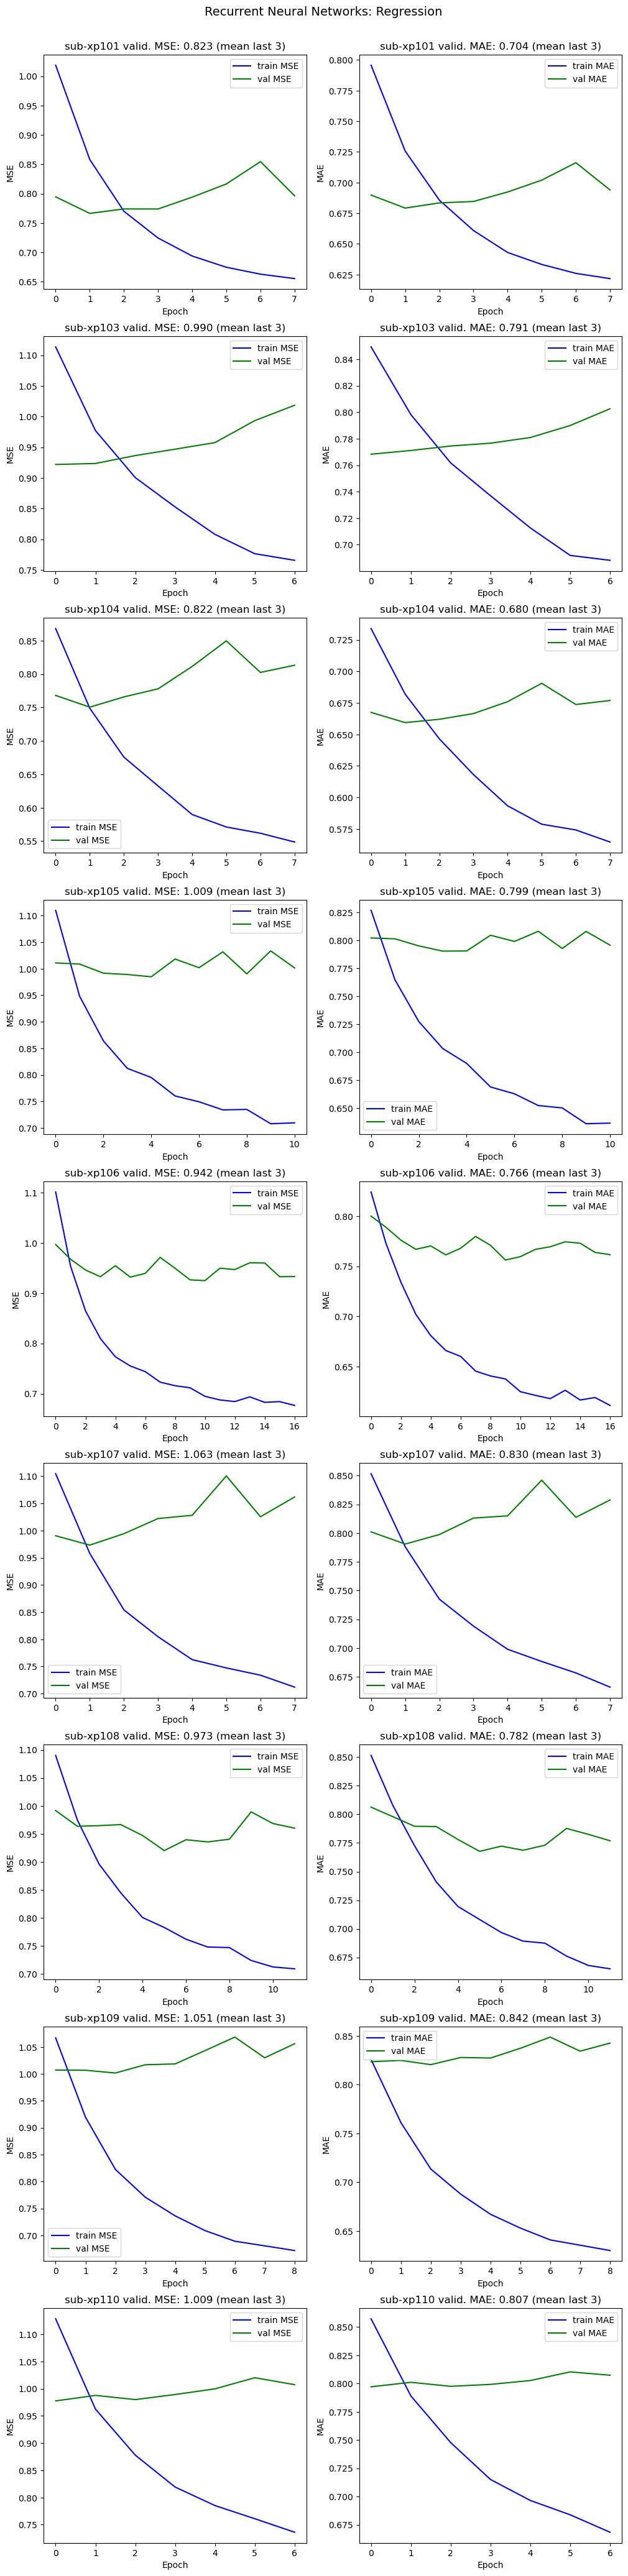

In [21]:
# Display the results. 
plot_rnn_regression(dict_history_reg, title = 'Recurrent Neural Networks: Regression')

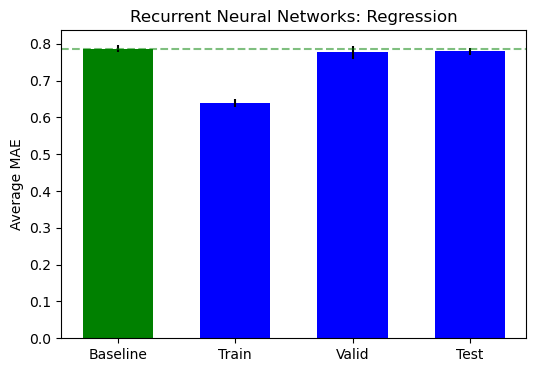

In [22]:
# Retrieve the average MAE and the standard error of the MAE. 
mae = [df_summary_reg['mae_baseline'].mean(), 
       df_summary_reg['mae_train'].mean(), 
       df_summary_reg['mae_valid'].mean(), 
       df_summary_reg['mae_test'].mean()]
mae_se = [np.std(df_summary_reg['mae_baseline']) / np.sqrt(df_summary_reg['mae_baseline'].shape[0]), 
          np.std(df_summary_reg['mae_train']) / np.sqrt(df_summary_reg['mae_train'].shape[0]), 
          np.std(df_summary_reg['mae_valid']) / np.sqrt(df_summary_reg['mae_valid'].shape[0]), 
          np.std(df_summary_reg['mae_test']) / np.sqrt(df_summary_reg['mae_test'].shape[0])]

# Display the average MAE and its standard error in a bar plot. 
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 4))
axes.bar(range(4), mae, width = 0.6, color = ['green', 'blue', 'blue', 'blue'])
axes.errorbar(range(4), mae, yerr = mae_se, fmt = 'None', color = 'black')
axes.axhline(mae[0], 0, 1, color = 'green', linestyle = 'dashed', alpha = 0.5)
axes.set_xticks(range(4), labels = ['Baseline', 'Train', 'Valid', 'Test'])
axes.set_ylabel('Average MAE')
axes.set_title('Recurrent Neural Networks: Regression');

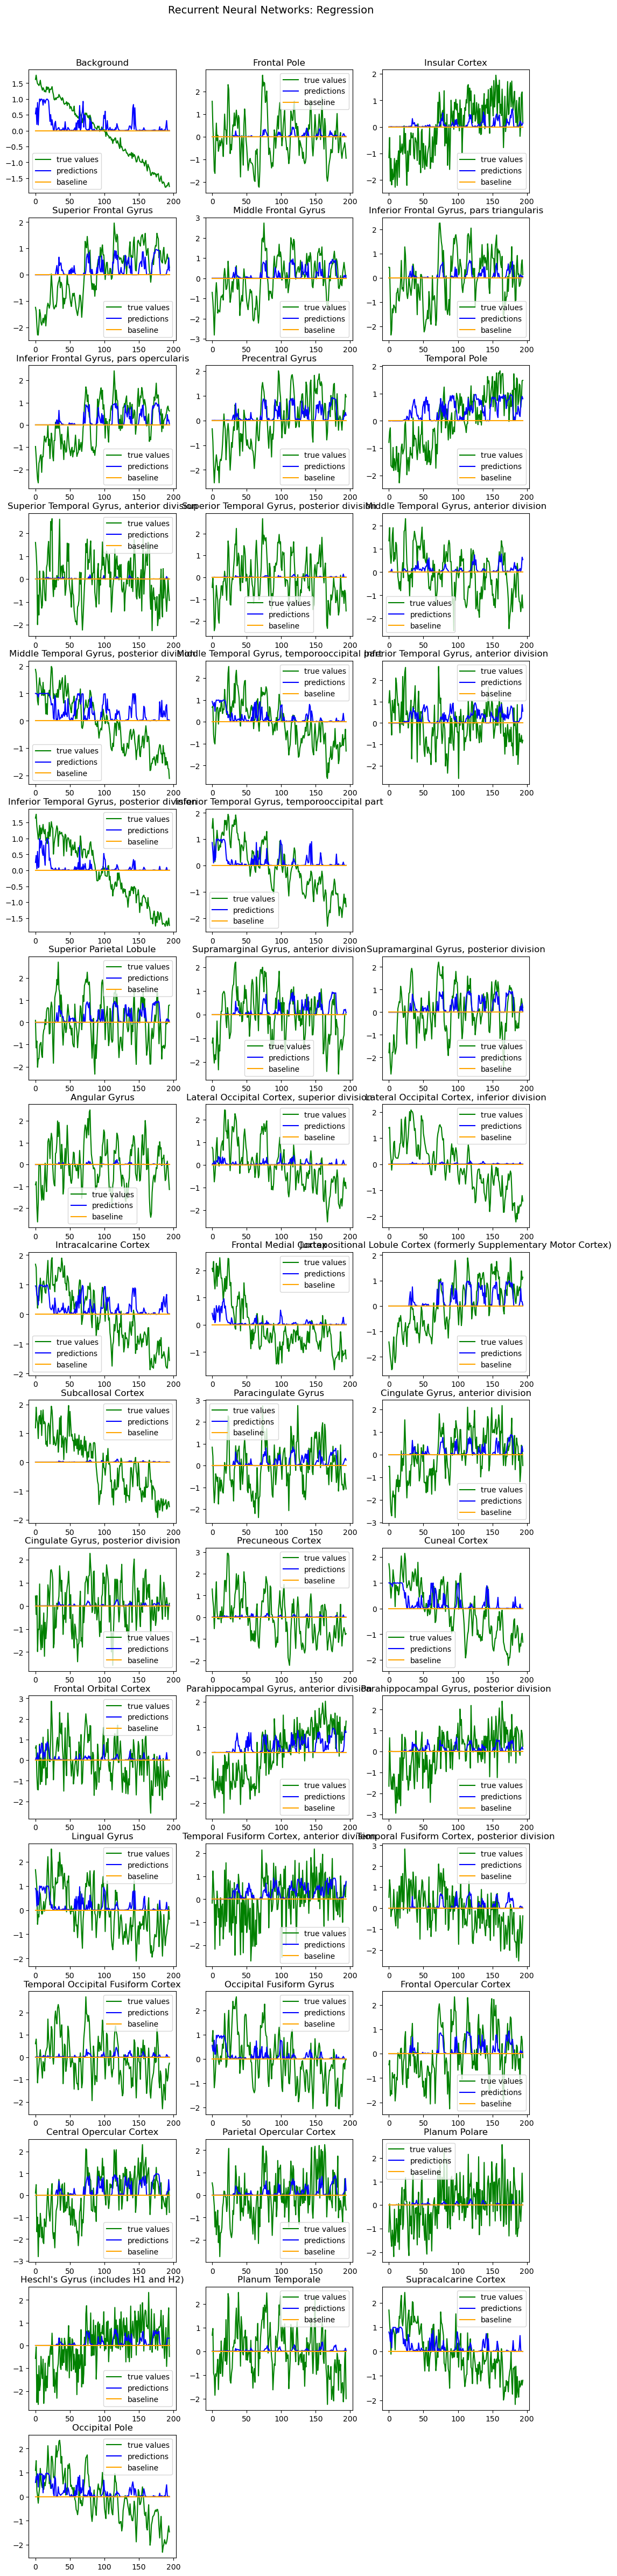

In [23]:
# Select the subject with the best predictions. 
subject = subjects[np.argmax(df_summary_reg['r2_model'])]

# Plot the true values, the predictions, and the baseline for all the targets. 
fig, axes = plt.subplots(nrows = 17, ncols = 3, figsize = (12, 60))
fig.suptitle('Recurrent Neural Networks: Regression', fontsize = 14, y = 0.9)

# Iterate through all brain regions. 
for brain_region_index in range(len(targets)):

    # Retrieve the true values, the predictions, and the baseline for the selected subject and sequence length. 
    Y_te = dict_targets_sequence_reg[subject]['fmriNF'][:, brain_region_index]
    Y_pred = dict_predictions_reg[subject][:, brain_region_index]
    Baseline = dict_baseline_sequence_reg[subject]['eegfmriNF'][:, brain_region_index]

    # Compute the row and column indexes. 
    row_index = brain_region_index // 3
    column_index = brain_region_index % 3

    # Plot the true values, the predictions, and the baseline. 
    axes[row_index, column_index].plot(Y_te,  color = 'green', label = 'true values')
    axes[row_index, column_index].plot(Y_pred,  color = 'blue', label = 'predictions')
    axes[row_index, column_index].plot(Baseline,  color = 'orange', label = 'baseline')
    axes[row_index, column_index].legend()
    axes[row_index, column_index].set_title(targets[brain_region_index])

# Hide empty subplots. 
axes[5, 2].set_visible(False)
axes[16, 1].set_visible(False)
axes[16, 2].set_visible(False)

## **3. Results**

We save the models in the appropriate directory. 

In [24]:
# Create directories for the results. 
if not os.path.isdir(results_path + 'classification/recurrent_neural_networks/'):
    os.mkdir(results_path + 'classification/recurrent_neural_networks/')
if not os.path.isdir(results_path + 'regression/recurrent_neural_networks/'):
    os.mkdir(results_path + 'regression/recurrent_neural_networks/')

# Save the models in the native Keras format. 
for subject in subjects:
    dict_models_class[subject].save(results_path + 'classification/recurrent_neural_networks/' + subject + '.keras')
    dict_models_reg[subject].save(results_path + 'regression/recurrent_neural_networks/' + subject + '.keras')